In [327]:
# CMPS140 Project - How to Become Top Earner in Airbnb?
# Tangni Wang, Tung Hoi Man, Yunxiang Fu
# {twang63, tuman, yfu7}@ucsc.edu

In [328]:
# To do:

# Split Training set, testing set in code?
# Convert attributes to numbers
# Generate graph
# Different model with different functions? Which function do we use?


In [329]:
import warnings
warnings.simplefilter("ignore")

import sklearn # sci-kit learn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [330]:
# Helper functions
def correction(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)    
    return (x)

def correction2(x):
    '''
    Columns value corrections
    '''
    if type(x)==str:
        x=x.replace('%','')
        x=float(x)/100.0
    return (x)

def to_int(x):
    '''
    Columns value corrections
    '''
    if x=='f':
        x=x.replace('f','0')
    elif x=='t':
        x=x.replace('t','1')
    else:
        x= '0'
    return int(x)

# def changeTime(x):
#     '''
#     change host_response_time columns from string into numerical.
#     '''
#     if x == 'within an hour':
#         x=x.replace('within an hour', '1')
#     elif x == 'within a few hours':
#         x=x.replace('within a few hours', '4')
#     elif x == 'within a day':
#         x=x.replace('within a day', '24')
#     elif x == 'a few days or more':
#         x=x.replace('a few days or more', '48')
#     else:
#         x='96'
        
#     return int(x)

def changeTime(x):
    '''
    change host_response_time columns from string into numerical.
    '''
    if x == 'within an hour':
        x='1'
    elif x == 'within a few hours':
        x='4'
    elif x == 'within a day':
        x='24'
    elif x == 'a few days or more':
        x='48'
    else:
        x='96'
        
    return x

def convertPolicy(x):
    '''
    Convert cancellation_policy columns from string into numerical.
    '''
    if x == 'strict':
        x=x.replace('strict', '1')
    elif x == 'moderate':
        x=x.replace('moderate', '3')
    elif x == 'flexible':
        x=x.replace('flexible', '5')
    else:
        x='3'
        
    return int(x)

In [331]:
# Parsing csv file
seattle_file_path = 'seattle_data/listings.csv'
seattle_data = pd.read_csv(seattle_file_path)
# seattle_data.columns

In [332]:
# Make a new attribute for prediction
seattle_data['new_score_reviews'] = seattle_data['reviews_per_month'] * seattle_data['review_scores_rating'] / 10
# seattle_data.describe()

In [333]:
# Define top performers and low performers
top90flag = seattle_data['new_score_reviews'].quantile(0.9)
upto25flag = seattle_data['new_score_reviews'].quantile(0.25)

seattle_data['top90'] = seattle_data.new_score_reviews >= top90flag
seattle_data['upto25'] = seattle_data.new_score_reviews <= upto25flag

print('The boundaries of top performer listings:', top90flag)
print('The boundaries of low performer listings:', upto25flag)

The boundaries of top performer listings: 44.109
The boundaries of low performer listings: 6.480000000000001


In [334]:
# Data Processing for training set

# # Drop useless columns
# useless_colmuns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
#     'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
#     'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
#     'host_response_rate', 'host_acceptance_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
#     'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'street', 
#     'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'market',
#     'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 
#     'room_type', 'bed_type', 'amenities', 'square_feet', 'guests_included', 'maximum_nights', 'calendar_updated', 
#     'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
#     'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_accuracy', 
#     'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
#     'review_scores_value', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 
#     'require_guest_phone_verification', 'calculated_host_listings_count', 'review_scores_rating', 'reviews_per_month'
# ]
# seattle_data.drop(useless_colmuns, axis=1)

# Remove $: price, weekly_price, security_deposit, extra_people, cleaning_fee
seattle_data['price']=seattle_data['price'].map(lambda x: correction(x))
seattle_data['weekly_price'] = seattle_data['weekly_price'].map(lambda x: correction(x))
seattle_data['monthly_price'] = seattle_data['monthly_price'].map(lambda x: correction(x))
seattle_data['security_deposit'] = seattle_data['security_deposit'].map(lambda x: correction(x))
seattle_data['extra_people'] = seattle_data['extra_people'].map(lambda x: correction(x))
seattle_data['cleaning_fee'] = seattle_data['cleaning_fee'].map(lambda x: correction(x))

# Convert string to number: host_response_time, cancellation_policy
seattle_data['host_response_time'] = seattle_data['host_response_time'].apply(changeTime).astype(int)
seattle_data['cancellation_policy'] = seattle_data['cancellation_policy'].map(lambda x: convertPolicy(x))

# Convert boolean t/f to int 1/0: host_is_superhost, host_identity_verified, instant_bookable
for i in seattle_data.columns:
    
    if set(seattle_data[i])=={'t','f'}:
        seattle_data[i]=seattle_data[i].apply(to_int)
        
    elif set(seattle_data[i]) == {'t','f',np.nan}:
        seattle_data[i]=seattle_data[i].apply(to_int)

# Fill missing value with reasonable values like 0 or 1.
seattle_data['new_score_reviews'].fillna(0, inplace = True)
seattle_data['accommodates'].fillna(0, inplace = True)
seattle_data['bathrooms'].fillna(0, inplace = True)
seattle_data['beds'].fillna(0, inplace = True)
seattle_data['price'].fillna(0, inplace = True)
seattle_data['weekly_price'].fillna(0, inplace = True)
seattle_data['monthly_price'].fillna(0, inplace = True)
seattle_data['security_deposit'].fillna(0, inplace = True)
seattle_data['cleaning_fee'].fillna(0, inplace = True)
seattle_data['extra_people'].fillna(0, inplace = True)
seattle_data['minimum_nights'].fillna(1, inplace = True)

# Relevant Features
seattle_features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy', 'new_score_reviews' 
                    ]

# Drop rows if any feature still has missing value
seattle_data = seattle_data[seattle_features].dropna()

# print(seattle_data[seattle_features])

In [335]:
# Needed features:
features = ['zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'weekly_price', 
                    'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights', 
                    'host_response_time', 'host_is_superhost', 'host_identity_verified', 'instant_bookable', 
                    'cancellation_policy'
                    ]

X = seattle_data[features]

# Statistic of seattle features
# X
# X.describe()

In [336]:
# Prediction target
y = seattle_data.new_score_reviews
# y
# y.describe()

In [337]:
# sns.pairplot(seattle_data)

In [338]:
# sns.distplot(y)

In [339]:
# Correlation
'''
The correlation coefficient, or simply the correlation, is an index that ranges from -1 to 1. 
When the value is near zero, there is no linear relationship. 
As the correlation gets closer to plus or minus one, the relationship is stronger. 
A value of one (or negative one) indicates a perfect linear relationship between two variables.
'''
# result: 
# stronger correlation: host_is_superhost, instant_bookable, host_response_time, bedrooms, price, cleaning fee
# weaker corr: accommodates, beds, bathrooms, host_identity_verified
# no corr: zipcode, weekly_price, monthly_price, security_deposit, extra_people, 

seattle_data.corr()

,zipcode,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,minimum_nights,host_response_time,host_is_superhost,host_identity_verified,instant_bookable,cancellation_policy,new_score_reviews
zipcode,1.000000,0.063138,0.060898,0.073895,0.050122,0.003354,-0.006622,-0.013433,-0.016103,0.002432,0.042380,0.000680,0.018866,0.001920,-0.018536,-0.010415,0.029796,-0.024690
accommodates,0.063138,1.000000,0.532683,0.770390,0.861516,0.651592,0.301711,0.247367,0.306145,0.630538,0.146996,0.017276,-0.038373,-0.002171,0.039831,0.023449,-0.282107,-0.104955
bathrooms,0.060898,0.532683,1.000000,0.605249,0.528149,0.511493,0.221150,0.135479,0.241305,0.444076,0.079381,0.006612,0.005250,0.000149,-0.011536,-0.048460,-0.137167,-0.133995
bedrooms,0.073895,0.770390,0.605249,1.000000,0.752707,0.626902,0.291247,0.201882,0.299854,0.562073,0.107739,0.012023,0.040230,-0.028767,-0.008321,-0.069701,-0.194251,-0.193207
beds,0.050122,0.861516,0.528149,0.752707,1.000000,0.587996,0.251519,0.192571,0.287862,0.584854,0.130200,0.002689,-0.029041,-0.023317,0.013437,0.024917,-0.239131,-0.120425
price,0.003354,0.651592,0.511493,0.626902,0.587996,1.000000,0.396304,0.277528,0.333627,0.576428,0.127736,0.017378,0.103279,0.012906,0.004013,-0.031303,-0.208189,-0.187675
weekly_price,-0.006622,0.301711,0.221150,0.291247,0.251519,0.396304,1.000000,0.674154,0.293928,0.297234,0.143805,0.002522,-0.011689,0.065377,0.028713,0.013097,-0.140139,-0.026105
monthly_price,-0.013433,0.247367,0.135479,0.201882,0.192571,0.277528,0.674154,1.000000,0.257274,0.266797,0.168516,0.005379,-0.099679,0.110126,0.036836,0.063153,-0.159159,0.033697
security_deposit,-0.016103,0.306145,0.241305,0.299854,0.287862,0.333627,0.293928,0.257274,1.000000,0.426527,0.192508,0.009552,-0.011325,0.052386,0.039475,0.011151,-0.241029,-0.075394
cleaning_fee,0.002432,0.630538,0.444076,0.562073,0.584854,0.576428,0.297234,0.266797,0.426527,1.000000,0.152467,0.030655,-0.045782,0.010445,0.084933,0.005888,-0.401276,-0.180943


In [340]:
# split training and testing set. Training = 80%. Testing = 20%
X_train, X_test, y_train_bm, y_test_bm = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3044, 17) (3044,)
(761, 17) (761,)


In [341]:
# Baseline model
# Make prediction by mean or median

from sklearn.dummy import DummyRegressor

# Create a dummy regressor
baseline_model = DummyRegressor(strategy='mean')

# "Train" dummy regressor
baseline_model.fit(X_train, y_train)
# print(dummy_mean)

# Predict
# print("Baseline model predicitions using testing set ")
# print(X2.head())
# print("The predictions are:")
# print(baseline_model.predict(X_test))
print("The score is:")
print(baseline_model.score(X_test, y_test))

The score is:
-3.2520698378668556e-06


Text(0, 0.5, 'Predictions')

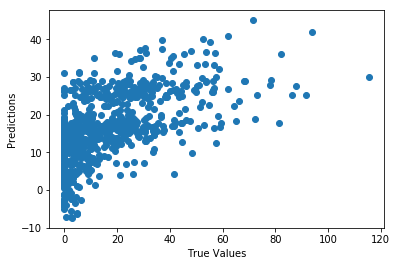

In [342]:
# Linear Regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
lm = linear_model.LinearRegression()
lin_model = lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [343]:
print(lin_model.score(X_test, y_test))

0.3223501586770844


In [344]:
# plt.figure(figsize=(10,10))
# plt.scatter(y_test, y_pred,color='red',label='GT')
# plt.plot(range(len(y_plot)),y_plot,color='black',label = 'pred')
# plt.legend()
# plt.show()

In [345]:
# The coefficients
print('Coefficients: \n', lin_model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-1.60501238e-02  9.59663259e-01  7.59530190e-02 -1.99980604e+00
 -1.03277111e-01 -1.20640722e-02  6.09900969e-04  2.14805937e-04
 -2.10722857e-03 -7.07223764e-02  4.66326070e-02 -1.61309119e-02
 -1.16148260e-01  1.04866759e+01  2.36693767e+00  9.50549861e+00
 -7.49124008e-01]
Mean squared error: 213.63
Variance score: 0.32


In [346]:
from sklearn.metrics import mean_absolute_error
mae_test = mean_absolute_error(y_pred, y_test)
print(mae_test)

10.661385130886293


In [347]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn import metrics

scores = cross_val_score(lin_model, X, y, cv=6)
print("Cross-validated scores:", scores)

# As you can see, the last fold improved the score of the original model — from 0.322 to 0.343

Cross-validated scores: [ 0.25070165  0.2813271   0.26080599  0.26064496 -1.60934324  0.34368981]


In [348]:
# Make cross validated predictions
# predictions = cross_val_predict(lin_model, X, y, cv=6)
# plt.scatter(y, predictions)

In [349]:
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)

Cross-Predicted Accuracy: -0.05019972478715129
